### Block 1: Setup and Imports

In [3]:
import os
import sys
import json
import random
import warnings
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print(f"Python: {sys.version}")
print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Set random seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Configuration
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50
NUM_CLASSES = 9
LEARNING_RATE = 1e-4
ENSEMBLE_SIZE = 3

# Paths
DATA_DIR = Path("/kaggle/input/hh25306/Dataset")
OUTPUT_DIR = Path("/kaggle/working")
OUTPUT_DIR.mkdir(exist_ok=True)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### Block 2: Data Loading and Exploration

Found classes: ['Endangered_species', 'algal_bloom', 'clear_water', 'deforestation', 'forest_fire', 'good_air', 'no_deforestation', 'plastic', 'polluted_air']
Total images found: 2295
Classes: ['Endangered_species', 'algal_bloom', 'clear_water', 'deforestation', 'forest_fire', 'good_air', 'no_deforestation', 'plastic', 'polluted_air']

Class distribution:
label
Endangered_species    500
good_air              323
no_deforestation      295
forest_fire           273
algal_bloom           257
polluted_air          219
deforestation         212
plastic               109
clear_water           107
Name: count, dtype: int64


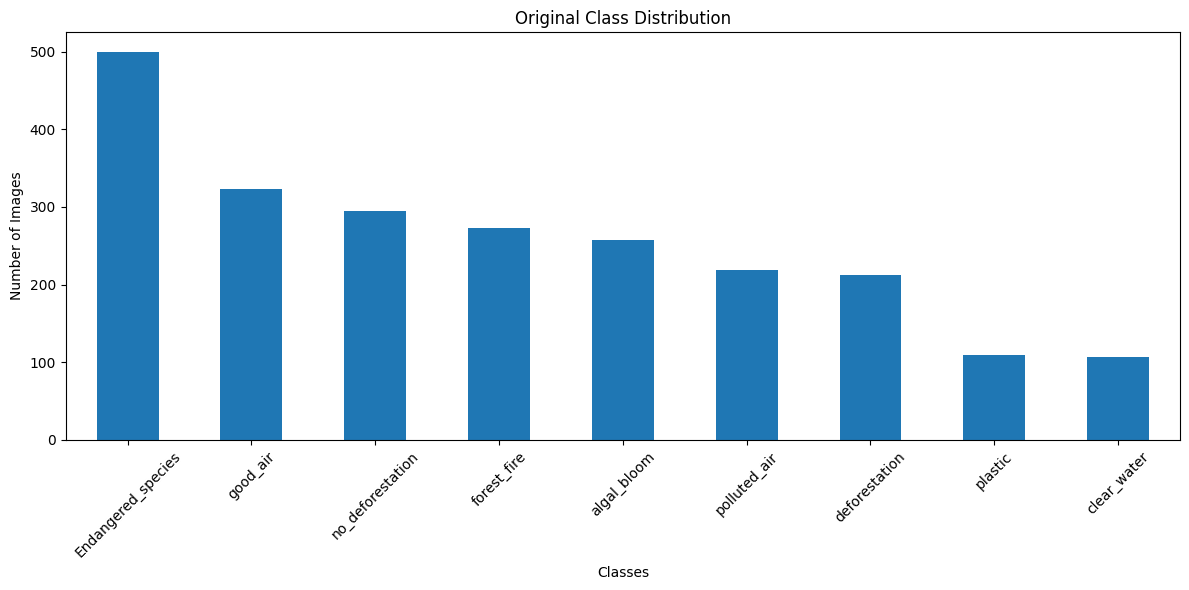

In [4]:
def load_dataset(data_dir):
    """Load dataset and create DataFrame with file paths and labels"""
    
    # Get all class directories
    class_dirs = [d for d in data_dir.iterdir() if d.is_dir()]
    classes = sorted([d.name for d in class_dirs])
    
    print(f"Found classes: {classes}")
    
    # Collect all image paths and labels
    image_paths = []
    labels = []
    
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}
    
    for class_dir in class_dirs:
        class_name = class_dir.name
        for img_path in class_dir.rglob('*'):
            if img_path.suffix.lower() in valid_extensions:
                image_paths.append(str(img_path))
                labels.append(class_name)
    
    # Create DataFrame
    df = pd.DataFrame({
        'filepath': image_paths,
        'label': labels
    })
    
    return df, classes

# Load dataset
df, original_classes = load_dataset(DATA_DIR)
print(f"Total images found: {len(df)}")
print(f"Classes: {original_classes}")

# Display class distribution
class_counts = df['label'].value_counts()
print("\nClass distribution:")
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title('Original Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Block 3: Handle Overlapping Classes (Bias Mitigation)

In [5]:
def create_class_mapping():
    """Create mapping to handle overlapping classes"""
    
    # Group overlapping classes to reduce bias
    class_mapping = {
        # Deforestation group
        'deforestation': 'forest_health',
        'no_deforestation': 'forest_health',
        
        # Air quality group  
        'good_air': 'air_quality',
        'polluted_air': 'air_quality',
        
        # Water quality group
        'clear_water': 'water_quality', 
        'algal_bloom': 'water_quality',
        
        # Keep distinct classes
        'Endangered_species': 'Endangered_species',
        'forest_fire': 'forest_fire',
        'plastic': 'plastic'
    }
    
    return class_mapping

def apply_bias_mitigation(df, use_grouping=True):
    """Apply bias mitigation strategy"""
    
    if use_grouping:
        # Option 1: Group overlapping classes
        class_mapping = create_class_mapping()
        df_processed = df.copy()
        df_processed['original_label'] = df_processed['label']
        df_processed['label'] = df_processed['label'].map(class_mapping)
        
        print("Applied class grouping to reduce bias")
        print(f"Reduced from {len(df['label'].unique())} to {len(df_processed['label'].unique())} classes")
        
    else:
        # Option 2: Keep original classes but add class weights
        df_processed = df.copy()
        print("Keeping original classes, will use class weights for balance")
    
    return df_processed

# Apply bias mitigation
USE_CLASS_GROUPING = True  # Set to False to keep original 9 classes
df_processed = apply_bias_mitigation(df, USE_CLASS_GROUPING)

# Update class information
final_classes = sorted(df_processed['label'].unique())
NUM_CLASSES = len(final_classes)

print(f"\nFinal classes ({NUM_CLASSES}): {final_classes}")
print("\nFinal class distribution:")
print(df_processed['label'].value_counts())

# Create label to index mapping
label_to_idx = {label: idx for idx, label in enumerate(final_classes)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Add numeric labels
df_processed['label_idx'] = df_processed['label'].map(label_to_idx)


Applied class grouping to reduce bias
Reduced from 9 to 6 classes

Final classes (6): ['Endangered_species', 'air_quality', 'forest_fire', 'forest_health', 'plastic', 'water_quality']

Final class distribution:
label
air_quality           542
forest_health         507
Endangered_species    500
water_quality         364
forest_fire           273
plastic               109
Name: count, dtype: int64


### Block 4: Data Splitting

In [6]:
def split_dataset(df, test_size=0.2, val_size=0.15, random_state=SEED):
    """Split dataset into train, validation, and test sets with stratification"""
    
    # First split: train+val vs test
    train_val_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        stratify=df['label_idx'],
        random_state=random_state
    )
    
    # Second split: train vs val
    val_size_adjusted = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_size_adjusted,
        stratify=train_val_df['label_idx'],
        random_state=random_state
    )
    
    return train_df, val_df, test_df

# Split dataset
train_df, val_df, test_df = split_dataset(df_processed)

print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Verify stratification
print("\nTrain set distribution:")
print(train_df['label'].value_counts())
print("\nValidation set distribution:")
print(val_df['label'].value_counts())
print("\nTest set distribution:")
print(test_df['label'].value_counts())


Train set: 1491 images
Validation set: 345 images
Test set: 459 images

Train set distribution:
label
air_quality           352
forest_health         330
Endangered_species    325
water_quality         236
forest_fire           177
plastic                71
Name: count, dtype: int64

Validation set distribution:
label
air_quality           82
forest_health         76
Endangered_species    75
water_quality         55
forest_fire           41
plastic               16
Name: count, dtype: int64

Test set distribution:
label
air_quality           108
forest_health         101
Endangered_species    100
water_quality          73
forest_fire            55
plastic                22
Name: count, dtype: int64


### Block 5: Data Augmentation and Preprocessing

In [7]:
def create_data_generators():
    """Create data generators with augmentation"""
    
    # Training data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2],
        channel_shift_range=0.1
    )
    
    # Validation and test data (no augmentation, only rescaling)
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    return train_datagen, val_test_datagen

def create_data_from_dataframe(datagen, df, batch_size=BATCH_SIZE, shuffle=True):
    """Create data generator from DataFrame"""
    
    generator = datagen.flow_from_dataframe(
        dataframe=df,
        x_col='filepath',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle,
        seed=SEED
    )
    
    return generator

# Create data generators
train_datagen, val_test_datagen = create_data_generators()

# Create data flows
train_generator = create_data_from_dataframe(train_datagen, train_df, shuffle=True)
val_generator = create_data_from_dataframe(val_test_datagen, val_df, shuffle=False)
test_generator = create_data_from_dataframe(val_test_datagen, test_df, shuffle=False)

print(f"Train generator: {train_generator.samples} samples")
print(f"Validation generator: {val_generator.samples} samples") 
print(f"Test generator: {test_generator.samples} samples")

# Calculate steps per epoch
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)
test_steps = len(test_generator)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")


Found 1491 validated image filenames belonging to 6 classes.
Found 345 validated image filenames belonging to 6 classes.
Found 459 validated image filenames belonging to 6 classes.
Train generator: 1491 samples
Validation generator: 345 samples
Test generator: 459 samples
Steps per epoch: 94
Validation steps: 22
Test steps: 29


### Block 6: Class Weight Calculation

In [8]:
def calculate_class_weights(df):
    """Calculate class weights for imbalanced dataset"""
    
    # Get class distribution
    y_labels = df['label_idx'].values
    
    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_labels),
        y=y_labels
    )
    
    # Create dictionary mapping
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    print("Class weights:")
    for idx, weight in class_weight_dict.items():
        class_name = idx_to_label[idx]
        print(f"{class_name}: {weight:.3f}")
    
    return class_weight_dict

# Calculate class weights
class_weights = calculate_class_weights(train_df)


Class weights:
Endangered_species: 0.765
air_quality: 0.706
forest_fire: 1.404
forest_health: 0.753
plastic: 3.500
water_quality: 1.053


### Block 7: Vision Transformer Model (TF 2.16 Compatible)

In [9]:
def create_simple_vit_model():
    """Simple, working ViT model using only standard Keras layers"""
    
    # Hyperparameters
    patch_size = 16
    num_patches = (IMG_SIZE // patch_size) ** 2
    projection_dim = 256
    num_heads = 8
    transformer_layers = 6
    
    # Input layer
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Extract patches using Conv2D
    patches = layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding='valid'
    )(inputs)
    
    # Reshape to sequence format
    patches = layers.Reshape((num_patches, projection_dim))(patches)
    
    # Add positional embeddings
    pos_emb = layers.Embedding(num_patches, projection_dim)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embeddings = pos_emb(positions)
    encoded_patches = patches + position_embeddings
    
    # Add class token
    class_token = tf.Variable(tf.random.normal([1, 1, projection_dim]) * 0.02, trainable=True)
    
    def add_cls_token(x):
        batch_size = tf.shape(x)[0]
        cls_tokens = tf.broadcast_to(class_token, [batch_size, 1, projection_dim])
        return tf.concat([cls_tokens, x], axis=1)
    
    encoded_patches = layers.Lambda(
        add_cls_token,
        output_shape=(num_patches + 1, projection_dim)
    )(encoded_patches)
    
    # Transformer blocks
    for i in range(transformer_layers):
        # Attention
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=projection_dim // num_heads
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(projection_dim * 2, activation='gelu')(x3)
        x3 = layers.Dense(projection_dim)(x3)
        encoded_patches = layers.Add()([x3, x2])
    
    # Classification head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    cls_token_final = layers.Lambda(lambda x: x[:, 0], output_shape=(projection_dim,))(representation)
    
    # Final layers
    x = layers.Dense(512, activation='gelu')(cls_token_final)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


### Block 8: Callbacks and Training Setup

In [10]:
def create_callbacks(model_name="vit_model"):
    """Create callbacks for training"""
    
    callbacks = [
        # Early stopping
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Model checkpoint
        ModelCheckpoint(
            filepath=f'{OUTPUT_DIR}/{model_name}_best.keras',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        
        # Learning rate reduction
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    return callbacks

# Create callbacks
callbacks = create_callbacks()
print("Callbacks created successfully!")


Callbacks created successfully!


### Block 9: Bagging Implementation and Ensemble

In [11]:
def train_bagged_models(num_models=ENSEMBLE_SIZE):
    """Train multiple models using bagging technique"""
    
    models = []
    histories = []
    val_accuracies = []
    
    for i in range(num_models):
        print(f"\n{'='*50}")
        print(f"Training Model {i+1}/{num_models}")
        print(f"{'='*50}")
        
        # Create bootstrap sample
        bootstrap_df = train_df.sample(frac=1.0, replace=True, random_state=SEED+i)
        
        # Create data generator for this bootstrap sample
        bootstrap_generator = create_data_from_dataframe(
            train_datagen, bootstrap_df, shuffle=True
        )
        
        # Create new model
        model = create_simple_vit_model()
        model.compile(
            optimizer=keras.optimizers.AdamW(
                learning_rate=LEARNING_RATE, 
                weight_decay=0.0001
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Create callbacks for this model
        model_callbacks = create_callbacks(f"vit_model_{i+1}")
        
        # Train model
        print(f"Starting training for Model {i+1}...")
        history = model.fit(
            bootstrap_generator,
            epochs=EPOCHS,
            validation_data=val_generator,
            callbacks=model_callbacks,
            class_weight=class_weights,
            verbose=2
        )
        
        # Evaluate on validation set
        print(f"Evaluating Model {i+1} on validation set...")
        val_loss, val_acc = model.evaluate(val_generator, verbose=0)
        val_accuracies.append(val_acc)
        
        print(f"Model {i+1} - Validation Accuracy: {val_acc:.4f}")
        
        models.append(model)
        histories.append(history)
    
    return models, histories, val_accuracies

# Train bagged models
print("Starting bagged model training...")
bagged_models, bagged_histories, bagged_val_accs = train_bagged_models()

# Select best model
best_model_idx = np.argmax(bagged_val_accs)
best_model = bagged_models[best_model_idx]
best_accuracy = bagged_val_accs[best_model_idx]

print(f"\nBest model: Model {best_model_idx + 1}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

# Save best model
best_model.save(f'{OUTPUT_DIR}/best_vit_model.keras')
print("Best model saved!")


Starting bagged model training...

Training Model 1/3
Found 1491 validated image filenames belonging to 6 classes.


I0000 00:00:1755892371.190971      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755892371.191666      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Starting training for Model 1...
Epoch 1/50


I0000 00:00:1755892399.169188     164 service.cc:148] XLA service 0x7cc974001510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755892399.170038     164 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755892399.170058     164 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755892401.472574     164 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755892409.599396     164 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.38551, saving model to /kaggle/working/vit_model_1_best.keras
94/94 - 71s - 753ms/step - accuracy: 0.2622 - loss: 1.6758 - val_accuracy: 0.3855 - val_loss: 1.4472 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.38551
94/94 - 21s - 229ms/step - accuracy: 0.3763 - loss: 1.4780 - val_accuracy: 0.3826 - val_loss: 1.4658 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_accuracy improved from 0.38551 to 0.46957, saving model to /kaggle/working/vit_model_1_best.keras
94/94 - 22s - 232ms/step - accuracy: 0.4661 - loss: 1.3016 - val_accuracy: 0.4696 - val_loss: 1.2536 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.46957
94/94 - 21s - 223ms/step - accuracy: 0.4930 - loss: 1.2338 - val_accuracy: 0.4522 - val_loss: 1.3171 - learning_rate: 1.0000e-04
Epoch 5/50

Epoch 5: val_accuracy improved from 0.46957 to 0.58841, saving model to /kaggle/working/vit_model_1_best.keras
94/

### Block 10: Ensemble Prediction

In [13]:
def ensemble_predict(models, generator):
    """Make ensemble predictions"""
    
    predictions = []
    
    for i, model in enumerate(models):
        print(f"Getting predictions from model {i+1}...")
        pred = model.predict(generator, verbose=0)
        predictions.append(pred)
    
    # Average predictions
    ensemble_pred = np.mean(predictions, axis=0)
    
    return ensemble_pred, predictions

# Get ensemble predictions on validation set
print("Creating ensemble predictions...")
val_ensemble_pred, val_individual_preds = ensemble_predict(bagged_models, val_generator)

# Get true labels for validation set
val_generator.reset()
val_true_labels = []
for i in range(len(val_generator)):
    batch_x, batch_y = val_generator[i]
    val_true_labels.extend(np.argmax(batch_y, axis=1))

val_true_labels = np.array(val_true_labels)
val_pred_labels = np.argmax(val_ensemble_pred, axis=1)

ensemble_val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
print(f"Ensemble validation accuracy: {ensemble_val_accuracy:.4f}")


Creating ensemble predictions...
Getting predictions from model 1...
Getting predictions from model 2...
Getting predictions from model 3...
Ensemble validation accuracy: 0.7420


### Block 11: Model Evaluation


Evaluating Best Individual Model...
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step
Best Individual Model Test Accuracy: 0.6885

Best Individual Model Classification Report:
                    precision    recall  f1-score   support

Endangered_species     0.7011    0.6100    0.6524       100
       air_quality     0.8641    0.8241    0.8436       108
       forest_fire     0.7627    0.8182    0.7895        55
     forest_health     0.6531    0.6337    0.6432       101
           plastic     0.4000    0.3636    0.3810        22
     water_quality     0.5326    0.6712    0.5939        73

          accuracy                         0.6885       459
         macro avg     0.6523    0.6535    0.6506       459
      weighted avg     0.6950    0.6885    0.6895       459



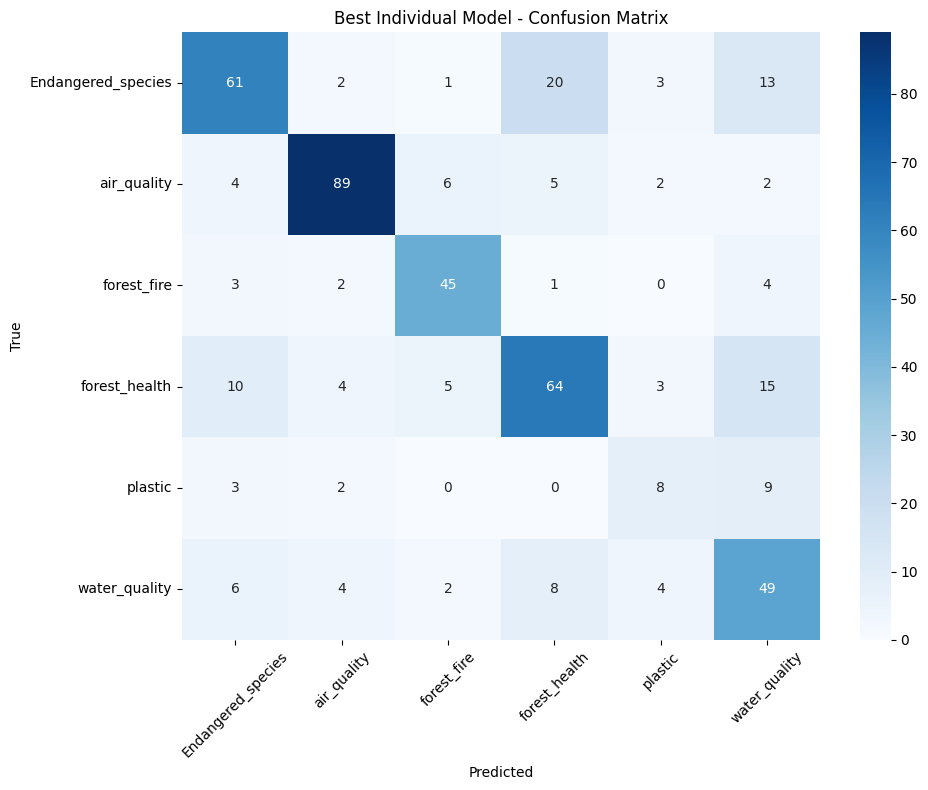

Getting predictions from model 1...
Getting predictions from model 2...
Getting predictions from model 3...

Ensemble Test Accuracy: 0.7451
Individual Best Model Test Accuracy: 0.6885
Improvement: 0.0566


In [14]:
def evaluate_model(model, test_generator, model_name="Model"):
    """Comprehensive model evaluation"""
    
    print(f"\nEvaluating {model_name}...")
    
    # Get predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    pred_labels = np.argmax(predictions, axis=1)
    
    # Get true labels
    true_labels = []
    for i in range(len(test_generator)):
        batch_x, batch_y = test_generator[i]
        true_labels.extend(np.argmax(batch_y, axis=1))
    true_labels = np.array(true_labels)
    
    # Calculate metrics
    test_accuracy = accuracy_score(true_labels, pred_labels)
    
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    
    # Classification report
    print(f"\n{model_name} Classification Report:")
    report = classification_report(
        true_labels, pred_labels, 
        target_names=final_classes,
        digits=4
    )
    print(report)
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=final_classes,
                yticklabels=final_classes)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return test_accuracy, pred_labels, true_labels

# Evaluate best individual model
best_test_acc, best_pred, best_true = evaluate_model(best_model, test_generator, "Best Individual Model")

# Evaluate ensemble
test_ensemble_pred, test_individual_preds = ensemble_predict(bagged_models, test_generator)
test_ensemble_labels = np.argmax(test_ensemble_pred, axis=1)

test_generator.reset()
test_true_labels = []
for i in range(len(test_generator)):
    batch_x, batch_y = test_generator[i]
    test_true_labels.extend(np.argmax(batch_y, axis=1))
test_true_labels = np.array(test_true_labels)

ensemble_test_accuracy = accuracy_score(test_true_labels, test_ensemble_labels)

print(f"\nEnsemble Test Accuracy: {ensemble_test_accuracy:.4f}")
print(f"Individual Best Model Test Accuracy: {best_test_acc:.4f}")
print(f"Improvement: {ensemble_test_accuracy - best_test_acc:.4f}")

# Save ensemble predictions
np.save(f'{OUTPUT_DIR}/ensemble_predictions.npy', test_ensemble_pred)


### Block 12: Visualization

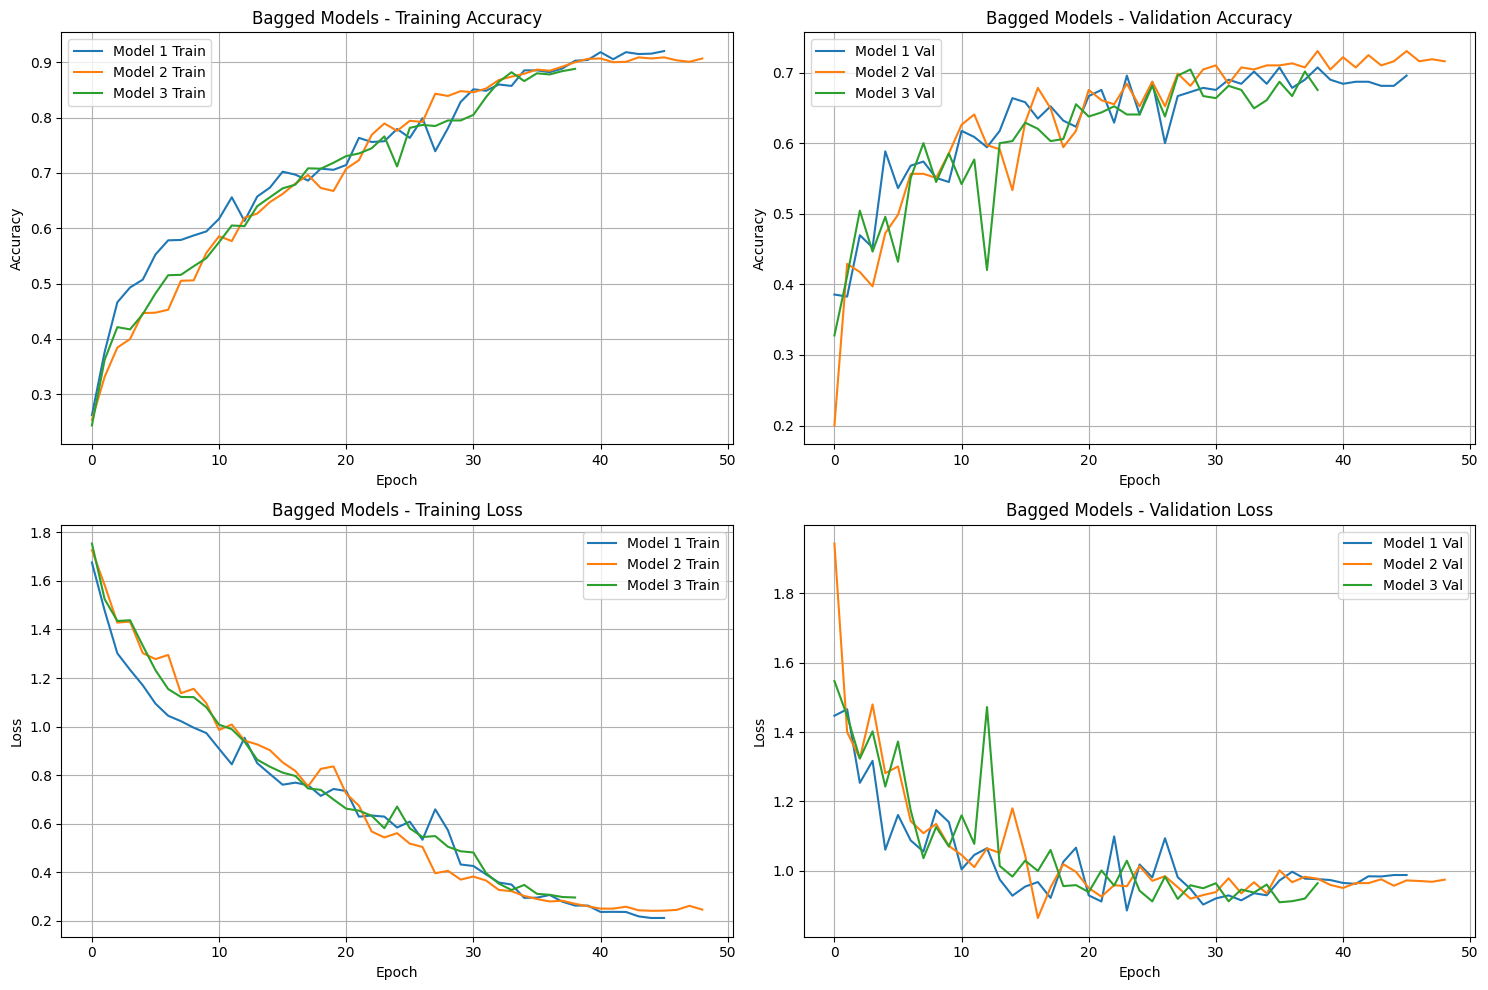

Sample predictions from best model:


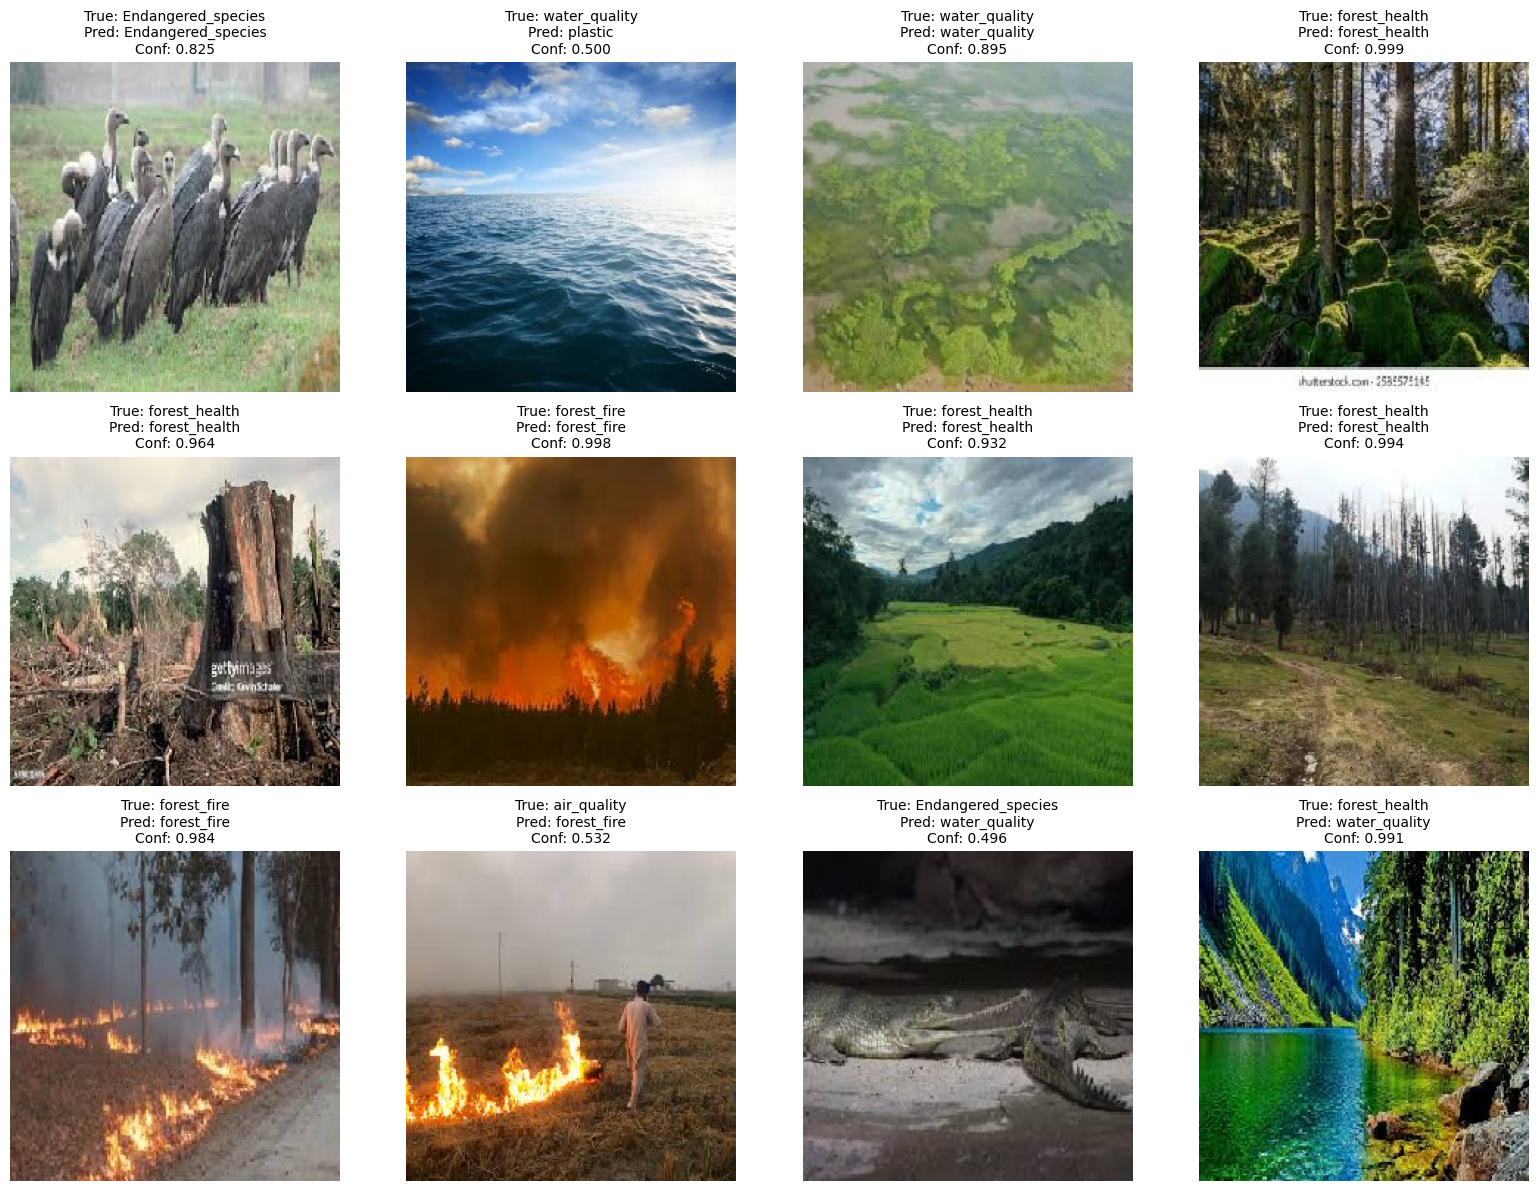

In [16]:
def plot_training_history(histories, title_prefix=""):
    """Plot training history for multiple models"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot accuracy
    for i, history in enumerate(histories):
        axes[0, 0].plot(history.history['accuracy'], label=f'Model {i+1} Train')
        axes[0, 1].plot(history.history['val_accuracy'], label=f'Model {i+1} Val')
    
    axes[0, 0].set_title(f'{title_prefix}Training Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    axes[0, 1].set_title(f'{title_prefix}Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot loss
    for i, history in enumerate(histories):
        axes[1, 0].plot(history.history['loss'], label=f'Model {i+1} Train')
        axes[1, 1].plot(history.history['val_loss'], label=f'Model {i+1} Val')
    
    axes[1, 0].set_title(f'{title_prefix}Training Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    axes[1, 1].set_title(f'{title_prefix}Validation Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training histories
plot_training_history(bagged_histories, "Bagged Models - ")

def visualize_sample_predictions(generator, model, num_samples=12):
    """Visualize sample predictions"""
    
    generator.reset()
    batch_x, batch_y = next(generator)
    
    # Get predictions
    predictions = model.predict(batch_x, verbose=0)
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(batch_y, axis=1)
    
    # Plot samples
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(batch_x))):
        img = batch_x[i]
        true_class = idx_to_label[true_labels[i]]
        pred_class = idx_to_label[pred_labels[i]]
        confidence = predictions[i][pred_labels[i]]
        
        axes[i].imshow(img)
        axes[i].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}', 
                         fontsize=10)
        axes[i].axis('off')
        
        # Color border based on correctness
        if true_labels[i] == pred_labels[i]:
            for spine in axes[i].spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(3)
        else:
            for spine in axes[i].spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
print("Sample predictions from best model:")
visualize_sample_predictions(test_generator, best_model)


### Block 13: Inference Function

In [21]:
def load_and_preprocess_image(image_path, target_size=(IMG_SIZE, IMG_SIZE)):
    """Load and preprocess a single image for inference"""
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, 0)  # Add batch dimension
    
    return image

def predict_single_image(image_path, model=None, use_ensemble=True):
    """Predict class for a single image"""
    
    # Preprocess image
    image = load_and_preprocess_image(image_path)
    
    if use_ensemble and len(bagged_models) > 1:
        # Use ensemble prediction
        predictions = []
        for model in bagged_models:
            pred = model.predict(image, verbose=0)
            predictions.append(pred)
        
        # Average predictions
        ensemble_pred = np.mean(predictions, axis=0)
        prediction = ensemble_pred
        
    else:
        # Use single model
        if model is None:
            model = best_model
        prediction = model.predict(image, verbose=0)
    
    # Get predicted class and confidence
    predicted_class_idx = np.argmax(prediction)
    predicted_class = idx_to_label[predicted_class_idx]
    confidence = prediction[predicted_class_idx]
    
    # Get top 3 predictions
    top_3_indices = np.argsort(prediction)[-3:][::-1]
    top_3_predictions = [
        (idx_to_label[idx], prediction[idx]) 
        for idx in top_3_indices
    ]
    
    return predicted_class, confidence, top_3_predictions

def interactive_inference():
    """Interactive inference function for user input"""
    
    print("=== Image Classification Inference ===")
    print("Enter the path to an image file for classification")
    print("Type 'quit' to exit")
    
    while True:
        image_path = input("\nEnter image path: ").strip()
        
        if image_path.lower() == 'quit':
            break
            
        if not os.path.exists(image_path):
            print("File not found. Please check the path.")
            continue
            
        try:
            # Make prediction
            pred_class, confidence, top_3 = predict_single_image(image_path, use_ensemble=True)
            
            print(f"\nPredicted Class: {pred_class}")
            print(f"Confidence: {confidence:.4f}")
            print("\nTop 3 Predictions:")
            for i, (class_name, conf) in enumerate(top_3, 1):
                print(f"{i}. {class_name}: {conf:.4f}")
                
            # Optionally display the image
            display_choice = input("\nDisplay image? (y/n): ").strip().lower()
            if display_choice == 'y':
                img = plt.imread(image_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.title(f'Predicted: {pred_class} (Confidence: {confidence:.3f})')
                plt.axis('off')
                plt.show()
                
        except Exception as e:
            print(f"Error processing image: {str(e)}")

# Example usage of inference function
print("Inference function ready. You can use:")
print("1. predict_single_image(image_path) for programmatic use")
print("2. interactive_inference() for interactive use")

# Example with a test image
sample_image_path = '/kaggle/input/testdataa1/algal1.jpg'
print(f"\nExample prediction for: {sample_image_path}")
pred_class, confidence, top_3 = predict_single_image(sample_image_path)
print(f"Predicted: {pred_class} (Confidence: {confidence:.4f})")


Inference function ready. You can use:
1. predict_single_image(image_path) for programmatic use
2. interactive_inference() for interactive use

Example prediction for: /kaggle/input/testdataa1/algal1.jpg


IndexError: index 5 is out of bounds for axis 0 with size 1

### Block 14: Save Models and Results

In [18]:
# Save all models
print("Saving all models...")

# Save individual bagged models
for i, model in enumerate(bagged_models):
    model.save(f'{OUTPUT_DIR}/bagged_model_{i+1}.keras')
    print(f"Saved bagged model {i+1}")

# Save best model (already saved during training)
print(f"Best model already saved as: {OUTPUT_DIR}/best_vit_model.keras")

# Save training results
results = {
    'final_classes': final_classes,
    'label_to_idx': label_to_idx,
    'idx_to_label': idx_to_label,
    'class_weights': {str(k): float(v) for k, v in class_weights.items()},
    'val_accuracies': [float(acc) for acc in bagged_val_accs],
    'best_model_idx': int(best_model_idx),
    'best_val_accuracy': float(best_accuracy),
    'ensemble_val_accuracy': float(ensemble_val_accuracy),
    'ensemble_test_accuracy': float(ensemble_test_accuracy),
    'individual_test_accuracy': float(best_test_acc),
    'num_classes': NUM_CLASSES,
    'img_size': IMG_SIZE,
    'model_config': {
        'ensemble_size': ENSEMBLE_SIZE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE
    }
}

# Save results as JSON
with open(f'{OUTPUT_DIR}/training_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Training results saved!")

# Save class mapping if grouping was used
if USE_CLASS_GROUPING:
    with open(f'{OUTPUT_DIR}/class_mapping.json', 'w') as f:
        json.dump(create_class_mapping(), f, indent=2)
    print("Class mapping saved!")

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)
print(f"Best Individual Model Accuracy: {best_test_acc:.4f}")
print(f"Ensemble Model Accuracy: {ensemble_test_accuracy:.4f}")
print(f"Improvement: {ensemble_test_accuracy - best_test_acc:.4f}")
print(f"Models saved in: {OUTPUT_DIR}")
print("="*50)


Saving all models...
Saved bagged model 1
Saved bagged model 2
Saved bagged model 3
Best model already saved as: /kaggle/working/best_vit_model.keras
Training results saved!
Class mapping saved!

TRAINING COMPLETE!
Best Individual Model Accuracy: 0.6885
Ensemble Model Accuracy: 0.7451
Improvement: 0.0566
Models saved in: /kaggle/working


### Block 15: Model Loading Function (UPDATED for Custom Layers)

In [ ]:
def load_saved_model(model_path):
    """Load a saved model for inference with custom objects"""
    
    try:
        # Register all custom objects
        custom_objects = {
            'PatchExtractor': PatchExtractor,
            'PatchEncoder': PatchEncoder,
            'AddClassToken': AddClassToken
        }
        
        with keras.utils.custom_object_scope(custom_objects):
            model = keras.models.load_model(model_path)
        print(f"Model loaded successfully from: {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None

def load_training_results(results_path):
    """Load training results and configuration"""
    
    try:
        with open(results_path, 'r') as f:
            results = json.load(f)
        print("Training results loaded successfully")
        return results
    except Exception as e:
        print(f"Error loading results: {str(e)}")
        return None

# Example usage for future sessions:
"""
# To load the best model in a new session:
# First define the custom layers (PatchExtractor, PatchEncoder, AddClassToken)
best_model = load_saved_model('/kaggle/working/best_vit_model.keras')
results = load_training_results('/kaggle/working/training_results.json')

# Reconstruct label mappings
if results:
    idx_to_label = {int(k): v for k, v in results['idx_to_label'].items()}
    label_to_idx = results['label_to_idx']
    final_classes = results['final_classes']
"""

print("Setup complete! All functions are ready for use.")
print("FIXED: Lambda layer output shape issue resolved with custom layers")
